In [86]:
import os
import pickle
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from nixtla.losses.numpy import mae, mse, mape, smape, rmse, pinball_loss

In [217]:
horizons = [30, 60, 120, 480, 960]
experiment_id = '20210504'
feature = 'ART'

maes_0 = []
maes_1 = []
#maes_M = []
trials_list = []
maes_MP = []
for horizon in horizons:
    results = pickle.load(open(f'../results/result_{horizon}_{feature}_{0}_{experiment_id}.p','rb'))
    y_true_0 = results['y_true']
    y_hat_0 = results['y_hat']

    results = pickle.load(open(f'../results/result_{horizon}_{feature}_{1}_{experiment_id}.p','rb'))
    y_true_1 = results['y_true']
    y_hat_1 = results['y_hat']

    trials_list.append(results['trials'])

    results = pickle.load(open(f'../results/result_{horizon}_BOTH_{0}_{experiment_id}.p','rb'))
    if feature == 'ART':
        index = 0
    else:
        index = 1
    y_true_M = results['y_true'][:,:,[index],:]
    y_hat_M = results['y_hat'][:,:,[index],:]

    results = pickle.load(open(f'../results/result_{horizon}_BOTH_{1}_{experiment_id}.p','rb'))
    y_true_MP = results['y_true'][:,:,[index],:]
    y_hat_MP = results['y_hat'][:,:,[index],:]

    maes_0.append(rmse(y_true_0, y_hat_0))
    maes_1.append(rmse(y_true_1, y_hat_1))
    #maes_M.append(rmse(y_true_M, y_hat_M))
    maes_MP.append(rmse(y_true_MP, y_hat_MP))

Text(0, 0.5, 'RMSE')

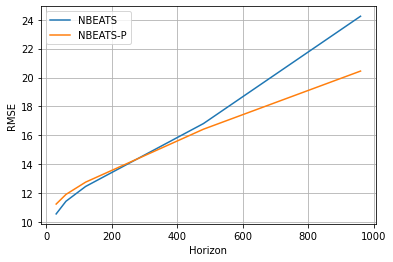

In [218]:
plt.plot(horizons, maes_0, label='NBEATS')
plt.plot(horizons, maes_1, label='NBEATS-P')
#plt.plot(horizons, maes_M, label='NBEATS-M')
#plt.plot(horizons, maes_MP, label='NBEATS-MP')
plt.grid()
plt.legend()
plt.xlabel('Horizon')
plt.ylabel('RMSE')

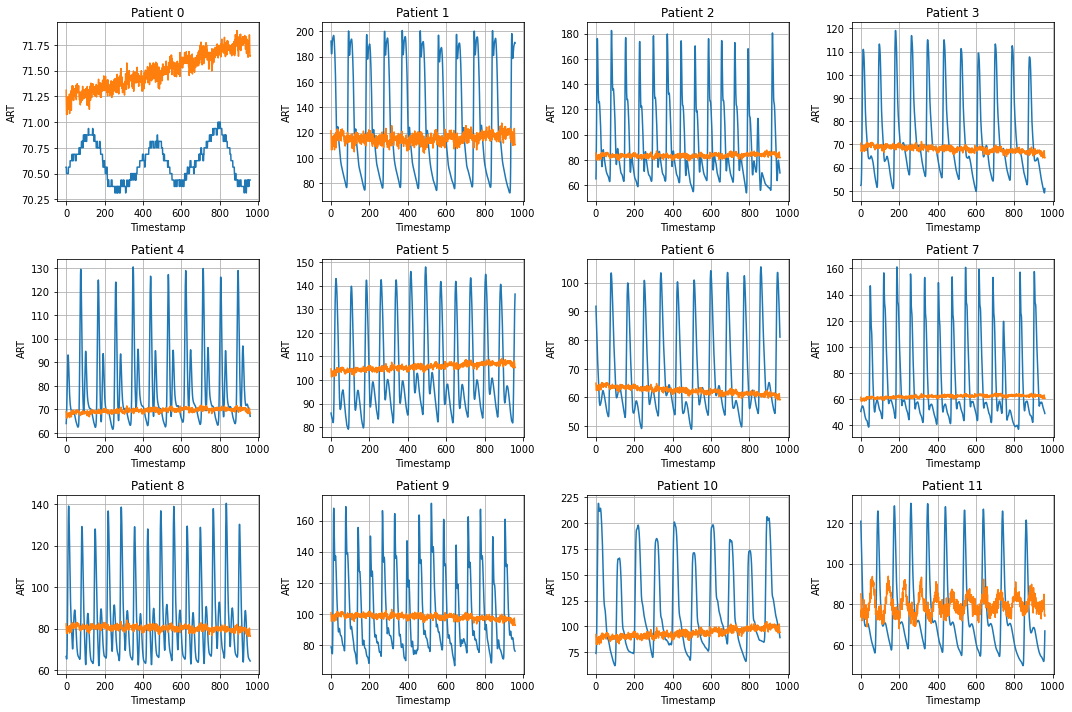

In [219]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize = (15,10))
for i in range(12):
    ax[i//4, i%4].plot(y_true_0[i,-1,0,:])
    ax[i//4, i%4].plot(y_hat_0[i,-1,0,:])
    ax[i//4, i%4].grid(True)
    ax[i//4, i%4].set_xlabel('Timestamp')
    ax[i//4, i%4].set_ylabel('ART')
    ax[i//4, i%4].set_title(f'Patient {i}')
plt.tight_layout()

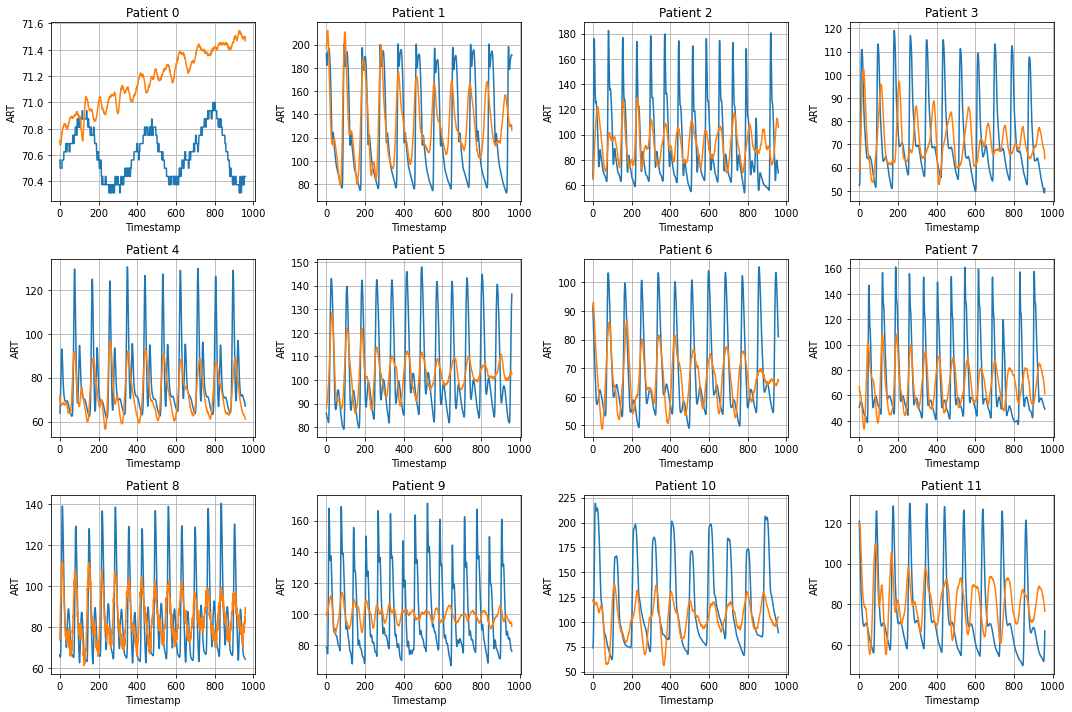

In [220]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize = (15,10))
for i in range(12):
    ax[i//4, i%4].plot(y_true_1[i,-1,0,:])
    ax[i//4, i%4].plot(y_hat_1[i,-1,0,:])
    ax[i//4, i%4].grid(True)
    ax[i//4, i%4].set_xlabel('Timestamp')
    ax[i//4, i%4].set_ylabel('ART')
    ax[i//4, i%4].set_title(f'Patient {i}')
plt.tight_layout()

In [221]:
def parse_trials(trials):
    # Initialize
    trials_dict = {'tid': [],
                   'val_loss': [],
                   'run_time': [],
                   #'trajectories': [],
                   'mc': []}
    for tidx in range(len(trials)):
        # Main
        try:
            trials_dict['val_loss'] += [trials.trials[tidx]['result']['loss']]
            trials_dict['tid']  += [trials.trials[tidx]['tid']]
            trials_dict['run_time'] += [trials.trials[tidx]['result']['run_time']]
            #trials_dict['trajectories'] += [trials.trials[tidx]['result']['trajectories']]

            # Model Configs
            mc = trials.trials[tidx]['result']['mc']
            trials_dict['mc'] += [mc]
        except:
            print('hola')
        
    trials_df = pd.DataFrame(trials_dict)
    return trials_df

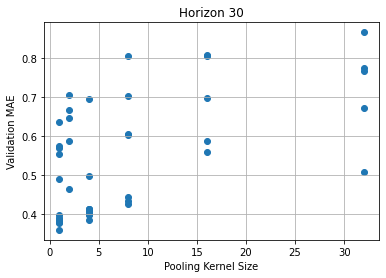

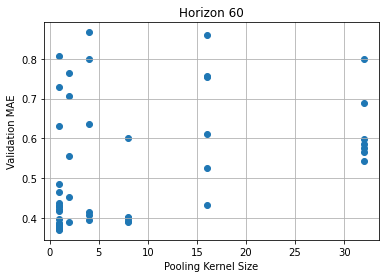

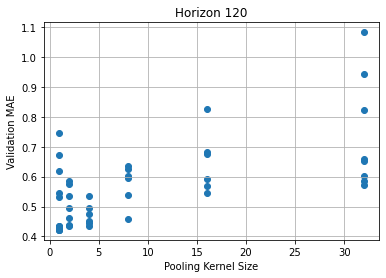

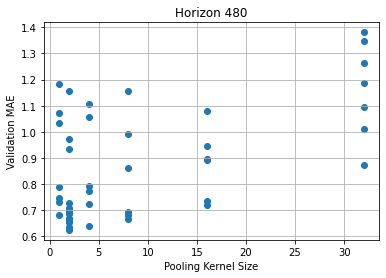

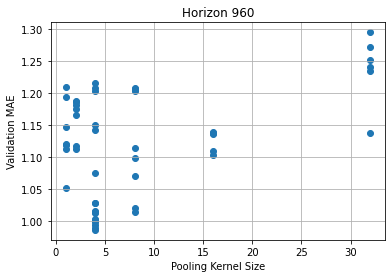

In [222]:
for i,h in enumerate(horizons):
    trials = parse_trials(trials_list[i])
    trials = pd.concat([trials.drop(['mc'], axis=1), trials['mc'].apply(pd.Series)], axis=1)
    for i, column in enumerate(trials.columns):
        if trials.dtypes[i]=='object':
            trials[column] = trials[column].astype(str)
            trials[column] = trials[column].fillna('None')
    trials['n_pooling_kernel'] = trials['n_pooling_kernel'].apply(lambda x: int(x.replace('(','').split(',')[0]))
    plt.scatter(trials['n_pooling_kernel'], trials['val_loss'].values[:,0].astype(float))
    plt.grid()
    plt.xlabel('Pooling Kernel Size')
    plt.ylabel('Validation MAE')
    plt.title(f'Horizon {h}')
    plt.show()